In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCH = 40
BATCH_SIZE = 16
print(DEVICE)

cuda


In [3]:
np_x = np.load('./data_feature_all_hour_new.npy').astype(np.float32)
np_y = np.load('./data_feature_all_hour_target.npy').astype(np.float32)
train_x, test_x, train_y, test_y = train_test_split(np_x, np_y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y.reshape(-1,1)))
test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y.reshape(-1,1)))
trainLoader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
testLoader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [5]:
class TransformerBlock(torch.nn.Module):

    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1) -> None:
        super(TransformerBlock, self).__init__()
        self.attn = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads, batch_first = True)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, ff_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout = torch.nn.Dropout(rate)
    def forward(self, inputs):
        attn_output, attn_score = self.attn(inputs, inputs, inputs)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        return self.layernorm2(ffn_output), attn_score

In [6]:
it = iter(trainLoader)
bat_x, bat_y = next(it)

In [7]:
class MedicModel(torch.nn.Module):

    def __init__(self) -> None:
        super(MedicModel, self).__init__()
        self.batch_norm = torch.nn.BatchNorm1d(48)
        self.norm1 = torch.nn.LayerNorm(184)
        self.norm2 = torch.nn.LayerNorm(256)
        self.norm3 = torch.nn.LayerNorm(128)
        self.lstm__184_256 = torch.nn.LSTM(184, 256, batch_first = True)
        self.lstm_256_128 = torch.nn.LSTM(256, 128, batch_first = True)
        self.trans = TransformerBlock(128, 64, 184)
   
        self.linear_i = torch.nn.Linear(48 * 128, 60)
        self.linear_o = torch.nn.Linear(60, 1)

    def forward(self,x):
        h = self.batch_norm(x)
        h = self.norm1(h)
        h, (h_i, c_i) = self.lstm__184_256(h)
        h = torch.tanh(h)
        h = self.norm2(h)
        h, (_, _) = self.lstm_256_128(h)
        h = torch.tanh(h)
        h = self.batch_norm(h)
        h = self.norm3(h)
        atten_out, s = self.trans(h)
        h = torch.tanh(h)
        h = torch.flatten(h, start_dim=1)
        h = self.linear_i(h)
        h = torch.sigmoid(h)
        h = self.linear_o(h)
        return h, s


In [8]:
model = MedicModel().cuda()
opti = torch.optim.Adam(model.parameters(), weight_decay=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()
train_losses = []
test_losses = []

In [9]:
for epoch in tqdm(range(EPOCH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred, _ = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred, _ = model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    train_losses.append(trainTloss / (len(trainLoader.dataset)//BATCH_SIZE))
    test_losses.append(testTloss / (len(testLoader.dataset)//BATCH_SIZE))


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


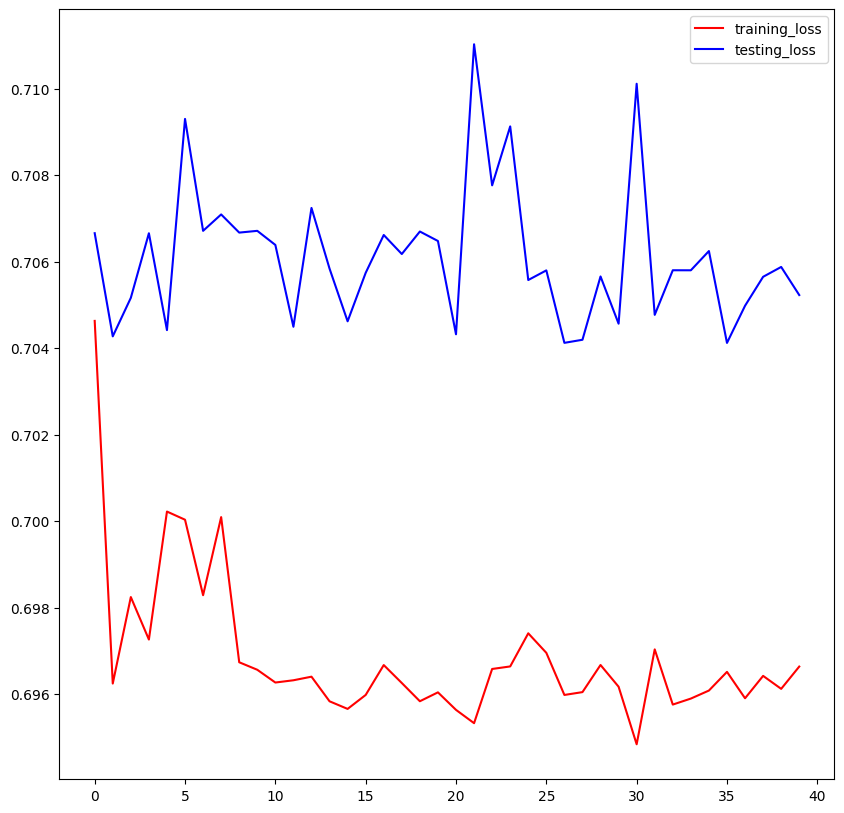

In [10]:
epochs = [ep for ep in range(EPOCH)]
plt.figure(figsize=(10, 10))
plt.plot(epochs, train_losses, label = "training_loss", color = 'r')
plt.plot(epochs, test_losses, label = "testing_loss", color = 'b')
plt.legend()
plt.show()

In [11]:
model.eval()

MedicModel(
  (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm1): LayerNorm((184,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm__184_256): LSTM(184, 256, batch_first=True)
  (lstm_256_128): LSTM(256, 128, batch_first=True)
  (trans): TransformerBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=128, out_features=184, bias=True)
      (1): ReLU()
      (2): Linear(in_features=184, out_features=128, bias=True)
    )
    (layernorm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    (layernorm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_i): Linear(in_features=6144, out_features=60, bias=Tr

In [12]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred, train_atten_score = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(trainLoader.dataset))
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred, test_atten_score = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(testLoader.dataset))

0.5285335102853351
0.5344827586206896


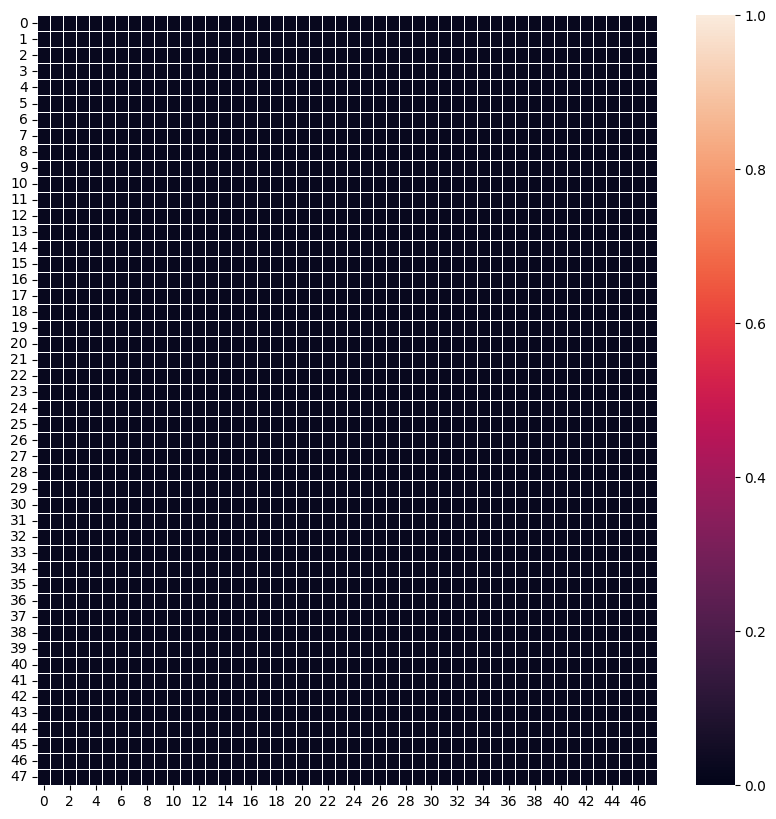

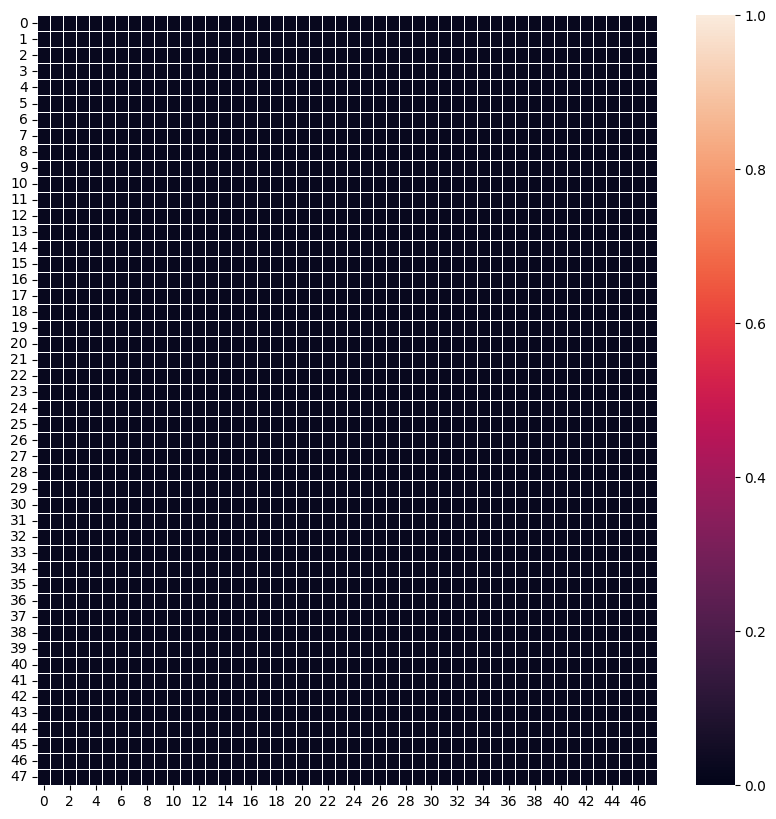

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(data = train_atten_score[0].cpu().detach().numpy(), linewidths=0.5, vmin = 0., vmax = 1.)
plt.show()
plt.figure(figsize=(10, 10))
sns.heatmap(data = test_atten_score[0].cpu().detach().numpy(), linewidths=0.5, vmin = 0., vmax = 1.)
plt.show()

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [15]:
with torch.no_grad():
    x, y = trainLoader.dataset[:]
    x = x.to(DEVICE)
    pred, _ = model(x)
    pred = torch.sigmoid(pred)
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score = pred)
    print(fpr)
    print(tpr)
    print(thr)

[0. 1.]
[0. 1.]
[1.4339067  0.43390664]


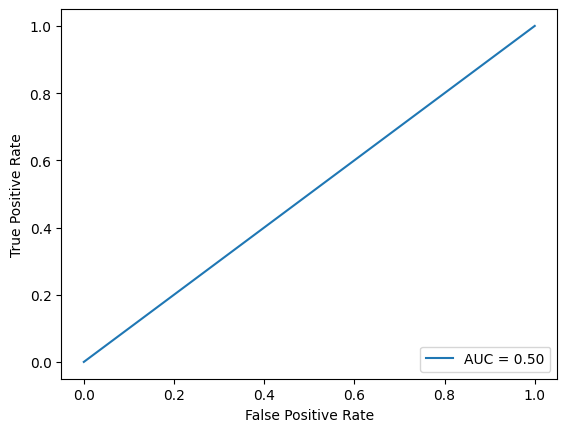

In [16]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()

In [17]:
with torch.no_grad():
    x, y = testLoader.dataset[:]
    x = x.to(DEVICE)
    pred, _ = model(x)
    pred = torch.sigmoid(pred)
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score=pred)
    print(fpr)
    print(tpr)
    print(thr)

[0. 1.]
[0. 1.]
[1.4339067  0.43390664]


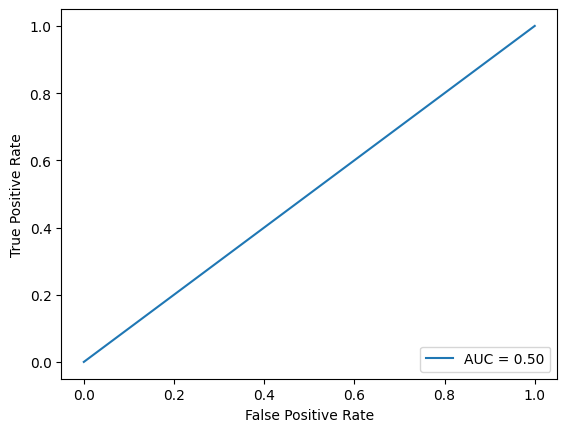

In [18]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()

# Final Model Design

In [19]:
class AttentionBaseMedicPredic(torch.nn.Module):

    def __init__(self) -> None:
        super(AttentionBaseMedicPredic, self).__init__()
        self.trans = TransformerBlock(184, 1, 256)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(184, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        h, attn_score = self.trans(x)
        h = h[:,-1]
        h = torch.nn.functional.relu(h)
        out = self.mlp(h)
        return out, attn_score


In [20]:
attention_model = AttentionBaseMedicPredic().cuda()
opti = torch.optim.Adam(attention_model.parameters(), weight_decay=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()
train_losses = []
test_losses = []

In [21]:
for epoch in tqdm(range(EPOCH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred, _ = attention_model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred, _ = attention_model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    train_losses.append(trainTloss / (len(trainLoader.dataset)//BATCH_SIZE))
    test_losses.append(testTloss / (len(testLoader.dataset)//BATCH_SIZE))

100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


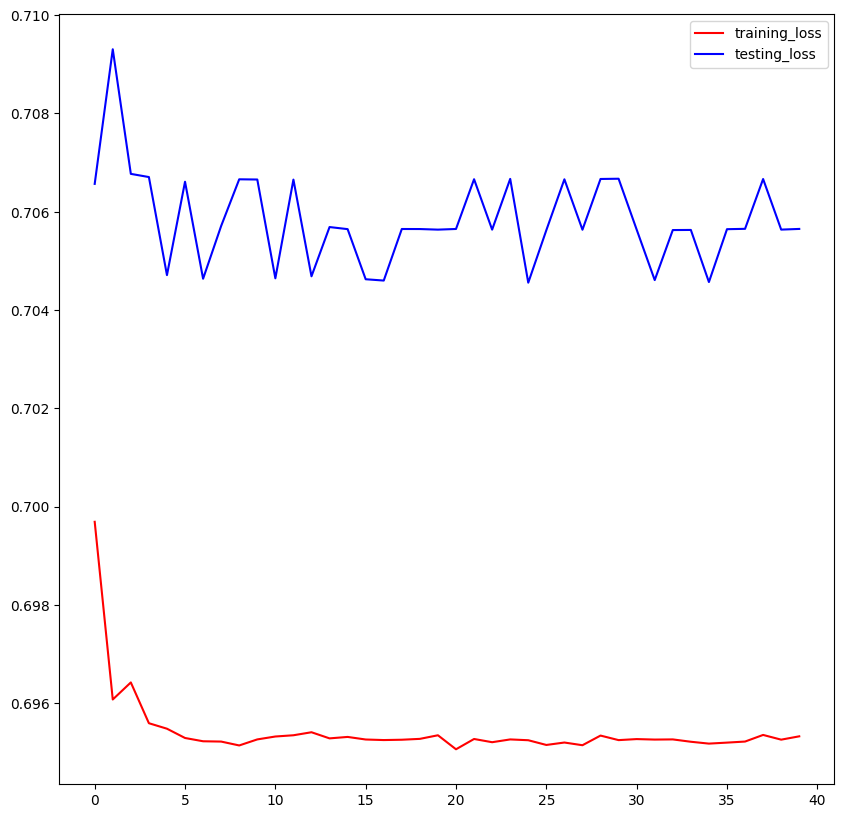

In [22]:
epochs = [ep for ep in range(EPOCH)]
plt.figure(figsize=(10, 10))
plt.plot(epochs, train_losses, label = "training_loss", color = 'r')
plt.plot(epochs, test_losses, label = "testing_loss", color = 'b')
plt.legend()
plt.show()

In [23]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred, train_atten_score = attention_model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(trainLoader.dataset))
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred, test_atten_score = attention_model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(testLoader.dataset))

0.5285335102853351
0.5344827586206896


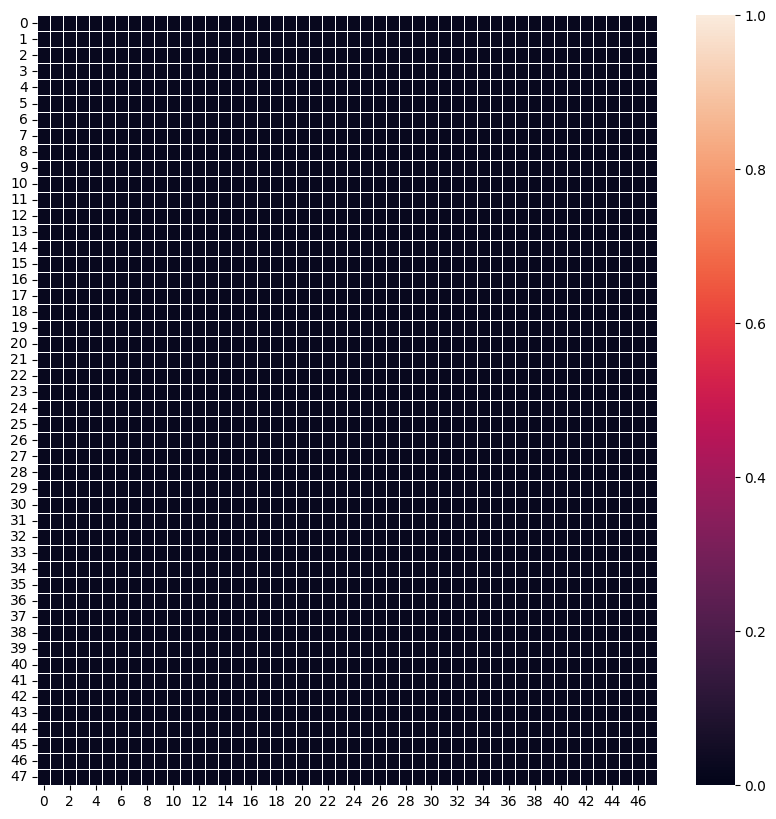

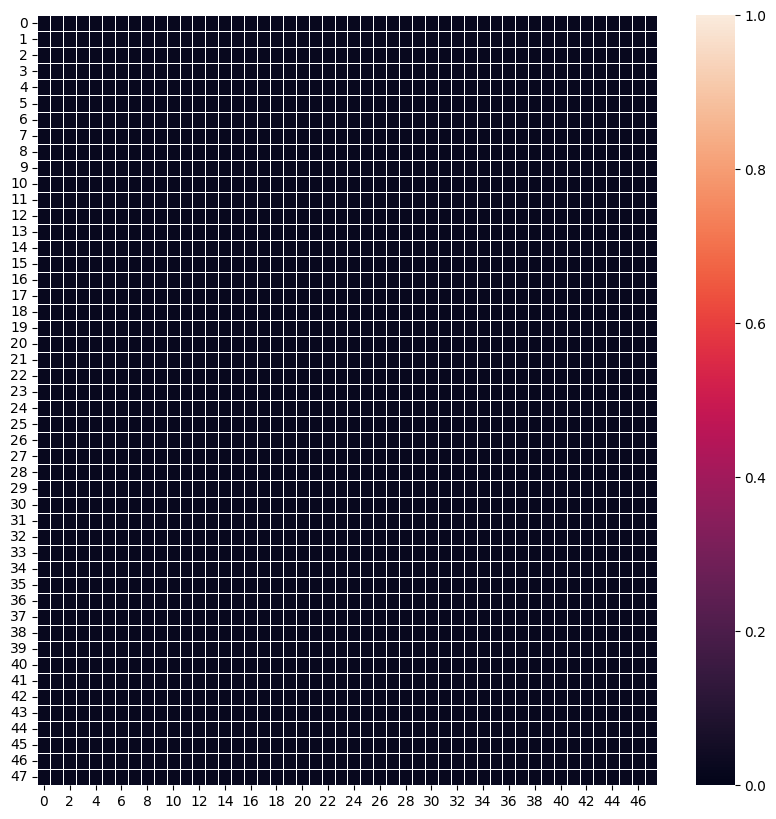

In [24]:
plt.figure(figsize=(10, 10))
sns.heatmap(data = train_atten_score[0].cpu().detach().numpy(), linewidths=0.5, vmin = 0., vmax = 1.)
plt.show()
plt.figure(figsize=(10, 10))
sns.heatmap(data = test_atten_score[0].cpu().detach().numpy(), linewidths=0.5, vmin = 0., vmax = 1.)
plt.show()

In [25]:
class LSTMBasedFinalStatePred(torch.nn.Module):

    def __init__(self) -> None:
        super(LSTMBasedFinalStatePred, self).__init__()
        self.lstm = torch.nn.LSTM(input_size = 184, hidden_size = 184 , batch_first = True)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(184, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        h_s, (h_c, c_c) = self.lstm(x)
        h = h_c[0]
        out = self.mlp(h)
        return out


In [26]:
lstm_model = LSTMBasedFinalStatePred().cuda()
opti = torch.optim.Adam(lstm_model.parameters(), weight_decay=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()
train_losses = []
test_losses = []

In [27]:
for epoch in tqdm(range(EPOCH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred = lstm_model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = lstm_model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    train_losses.append(trainTloss / (len(trainLoader.dataset)//BATCH_SIZE))
    test_losses.append(testTloss / (len(testLoader.dataset)//BATCH_SIZE))

100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


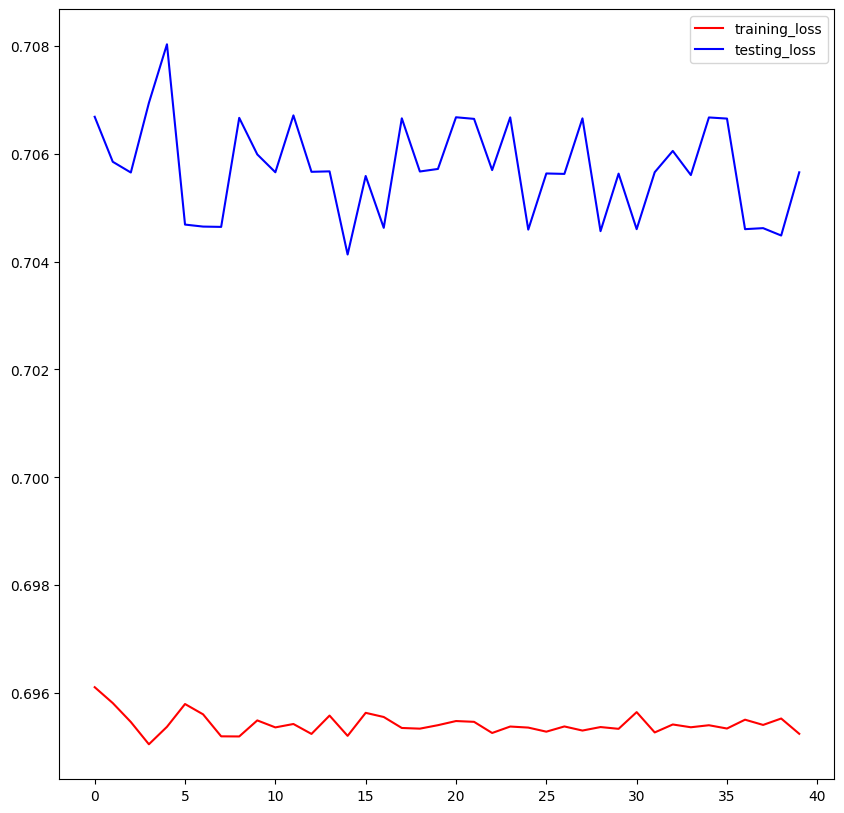

In [28]:
epochs = [ep for ep in range(EPOCH)]
plt.figure(figsize=(10, 10))
plt.plot(epochs, train_losses, label = "training_loss", color = 'r')
plt.plot(epochs, test_losses, label = "testing_loss", color = 'b')
plt.legend()
plt.show()

In [29]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = lstm_model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(trainLoader.dataset))
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = lstm_model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(testLoader.dataset))

0.5285335102853351
0.5344827586206896
